source link https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide

# SARIMA 

In [327]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from datetime import datetime

from itertools import product

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

#%matplotlib inline

## Quarterly views data

In [328]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

data = pd.read_csv('../data/catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)
data_column_name = "total"

#transform
start_date = datetime(2009,1,1)
end_date = datetime(2021,1,1)
data = data[start_date:end_date]

data = data.asfreq(pd.infer_freq(data.index))

data.head()

,total
date,
2009-01-01,20322
2009-02-01,20613
2009-03-01,22704
2009-04-01,20276
2009-05-01,20669


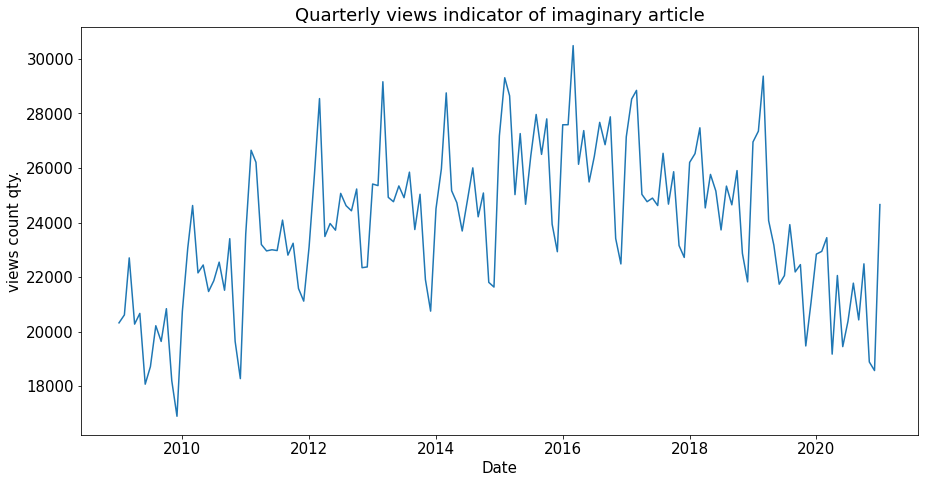

In [329]:
def print_data(data):
    plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
    plt.plot(data)
    plt.title('Quarterly views indicator of imaginary article')
    plt.ylabel('views count qty.')
    plt.xlabel('Date')

print_data(data)
#plt.xticks(rotation=90)
#plt.grid(True)
#plt.show()

## STL decomposition

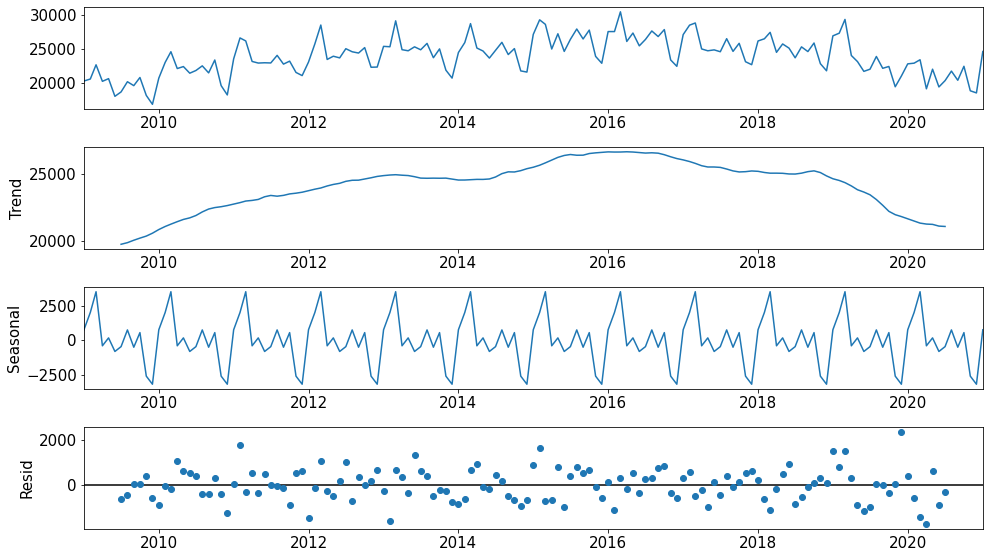

In [330]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(data,model='additive')
fig = result.plot()

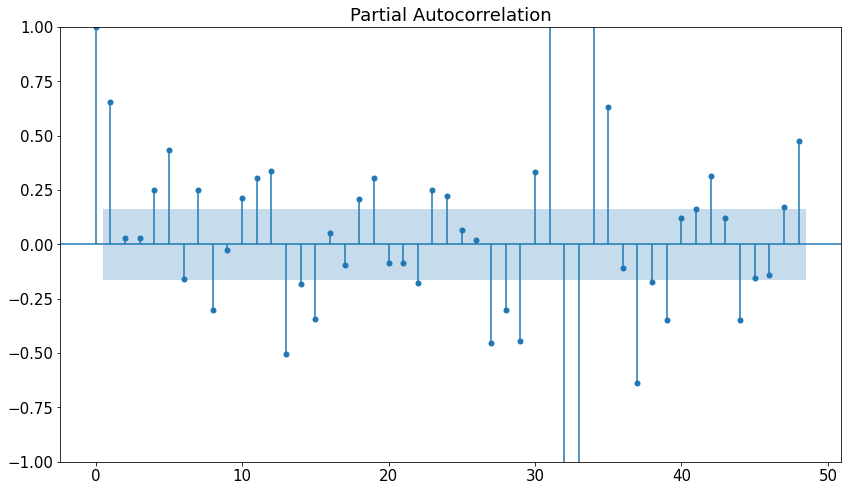

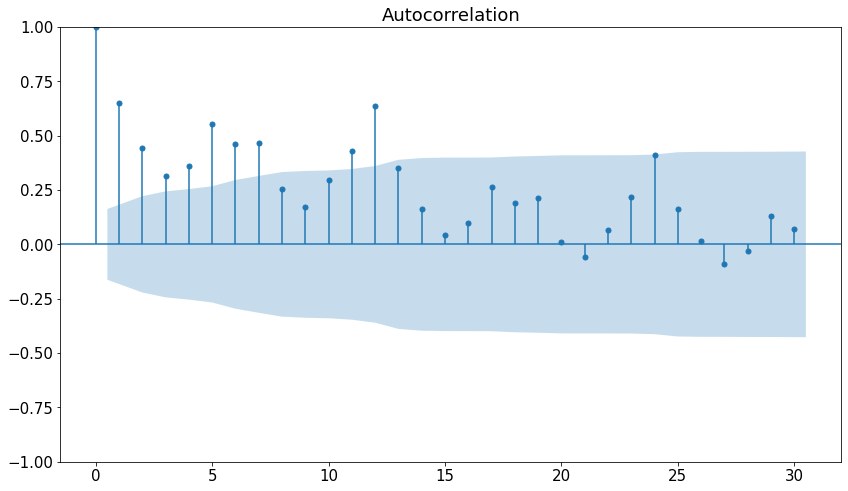

In [331]:
pacf_result = plot_pacf(data[data_column_name], lags=48)
acf_result = plot_acf(data[data_column_name], lags=30)

In [332]:
# Take the log difference to make data stationary
def check_stationarity(ts) -> bool:
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
        print(f'ADF Statistic: {adf}')
        print(f'p-value: {pvalue}')
        return True
    else:
        print('The series is NOT stationary')
        return False

integration_param = 1

while True:
    data[data_column_name] = data[data_column_name].diff()
    data = data.drop(data.index[0])
    #print_data(data)
    if check_stationarity(data[data_column_name]) == True:
        break
    integration_param += 1

print("ARIMA/SARIMA integration param 'd' :", integration_param)
data.head()

The series is NOT stationary
The series is stationary
ADF Statistic: -7.732031085308544
p-value: 1.1187722302046223e-11
ARIMA/SARIMA integration param 'd' : 2


,total
date,
2009-03-01,1800.0
2009-04-01,-4519.0
2009-05-01,2821.0
2009-06-01,-2988.0
2009-07-01,3240.0


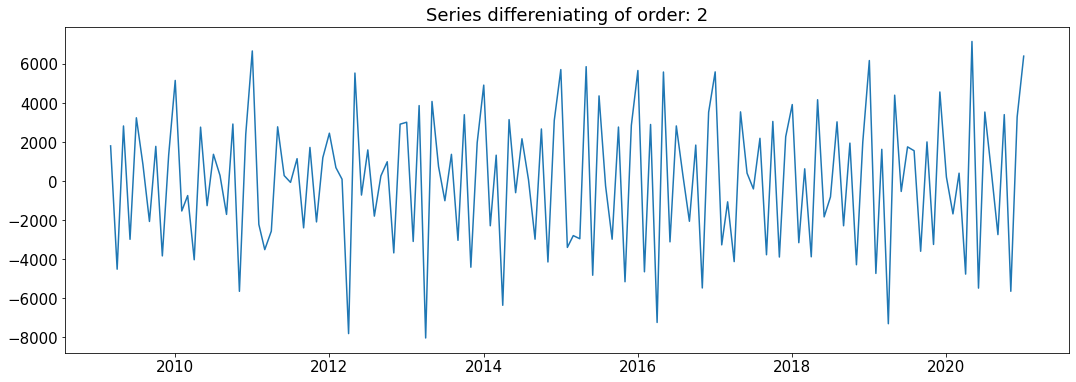

In [336]:
plt.figure(figsize=[18, 6]); # Set dimensions for figure
plt.plot(data[data_column_name])
plt.title("Series differeniating of order: {0}".format(integration_param))
plt.show()

In [92]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data[data_column_name])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.630742316268341
p-value: 5.723549368819163e-09


In [109]:
print(ad_fuller_result)

(-6.630742316268341, 5.723549368819163e-09, 5, 73, {'1%': -3.5232835753964475, '5%': -2.902030597326081, '10%': -2.5883710883843123}, -130.61220148933856)


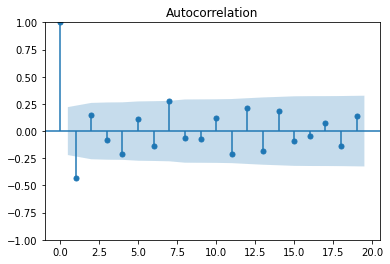

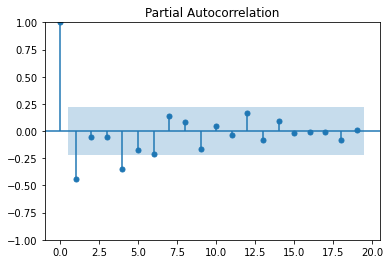

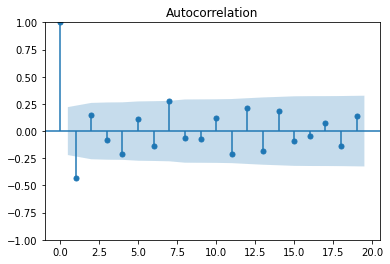

In [93]:
plot_pacf(data[data_column_name])
plot_acf(data[data_column_name])

In [94]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []

    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [95]:
param_cases = {
    "p": range(0, 4, 1),
    "q": range(0, 4, 1),
    "P": range(0, 4, 1),
    "Q": range(0, 4, 1)
}

p = param_cases["p"]
d = 1
q = param_cases["q"]
P = param_cases["P"]
D = 1
Q = param_cases["Q"]
s = 4 # aka `m` from SARIMA formula

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [96]:
result_df = optimize_SARIMA(parameters_list, d, D, s, data[data_column_name])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 2)",-114.461063
1,"(0, 2, 1, 2)",-114.257864
2,"(0, 2, 1, 3)",-113.501910
3,"(0, 2, 0, 3)",-113.086724
4,"(0, 2, 2, 2)",-113.072676
...,...,...
251,"(0, 0, 1, 1)",-24.763654
252,"(0, 0, 0, 1)",-23.133511
253,"(1, 0, 0, 0)",-19.080781
254,"(0, 0, 1, 0)",2.583029


In [97]:
print(result_df["(p,q)x(P,Q)"].iloc[0])

(0, 2, 0, 2)


In [98]:
best_params = result_df["(p,q)x(P,Q)"].iloc[0]

best_p = best_params[0]
best_q = best_params[1]
best_P = best_params[2]
best_Q = best_params[3]

model_params = (best_p, d, best_q)
model_seasonal_params = (best_P, D, best_Q, s)

best_model = SARIMAX(data[data_column_name], order=model_params, seasonal_order=model_seasonal_params).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                   79
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood                  62.231
Date:                           Fri, 13 May 2022   AIC                           -114.461
Time:                                   20:14:57   BIC                           -102.941
Sample:                                        0   HQIC                          -109.865
                                            - 79                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5822      0.139    -11.350      0.000      -1.855      -1.309
ma.L2          0.5926      0.112      5.271

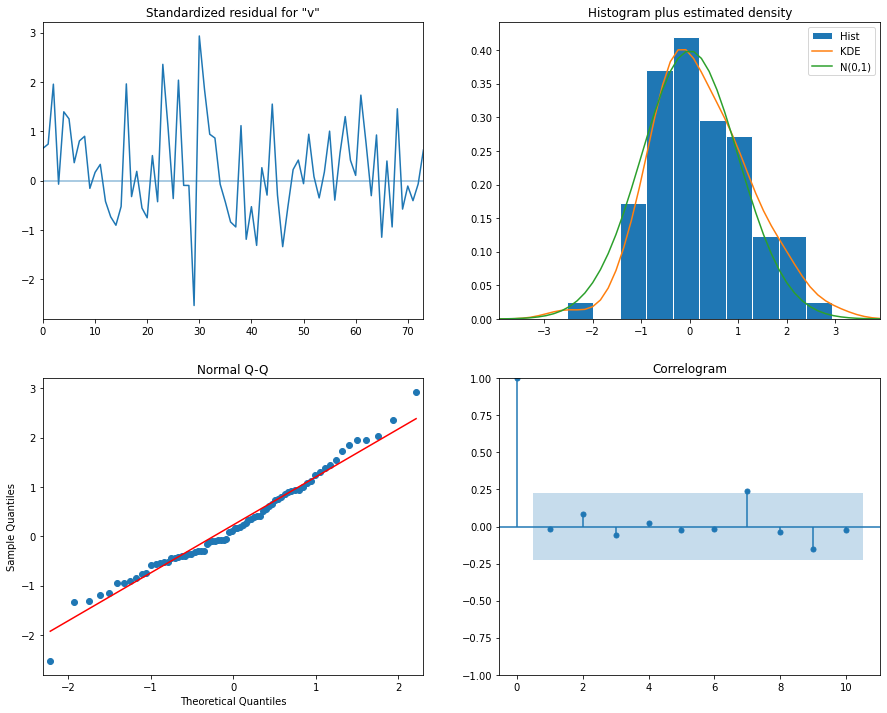

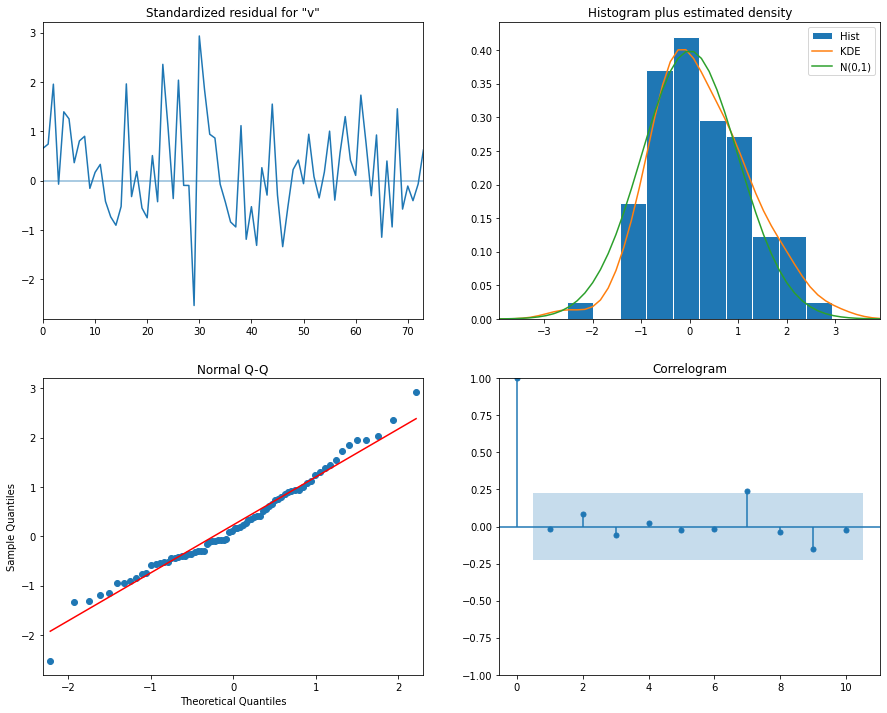

In [99]:
best_model.plot_diagnostics(figsize=(15,12))

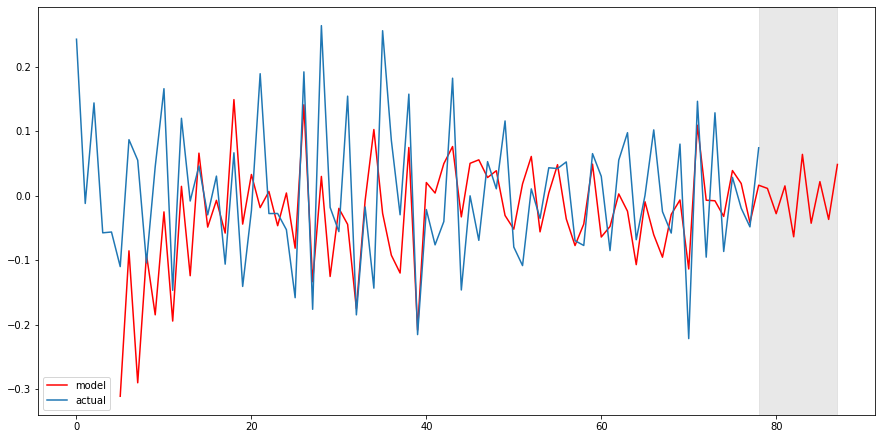

In [100]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN

forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data[data_column_name], label='actual')
plt.legend()

plt.show()

In [101]:
print(data.shape)
print(forecast)

(79, 3)
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
        ...   
83    0.064269
84   -0.042462
85    0.021984
86   -0.036575
87    0.048606
Length: 88, dtype: float64


## Exponential Smoothing (Holt-Winters) 

In [102]:
data1 = pd.read_csv('../data/article_statistics.csv')
data1.shape

(84, 2)

In [106]:
train, test = data1.iloc[:75,:], data1.iloc[74:,:]

In [107]:
model = ExponentialSmoothing(train[data_column_name], seasonal='mul', seasonal_periods=4).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

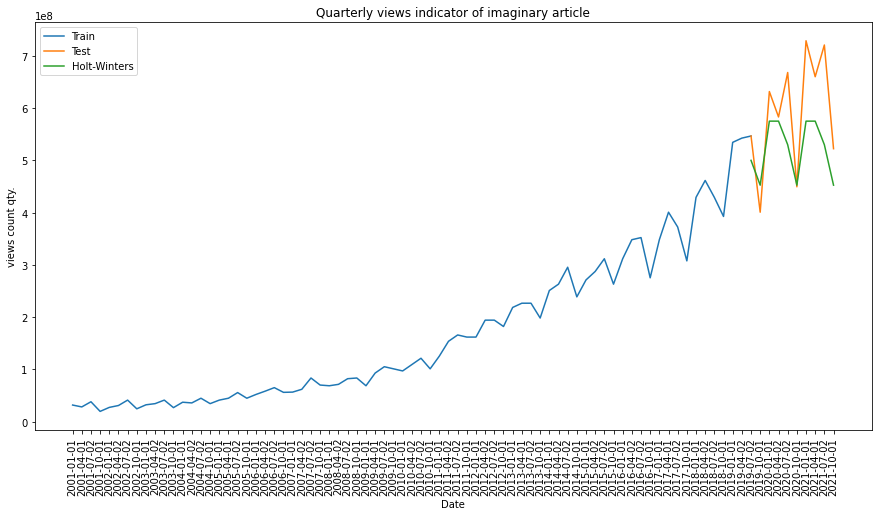

In [108]:
plt.figure(figsize=(15, 7.5))
plt.plot(train['date'], train[data_column_name], label='Train')
plt.plot(test['date'], test[data_column_name], label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.title('Quarterly views indicator of imaginary article')
plt.ylabel('views count qty.')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.legend()
plt.show()